Device: cuda


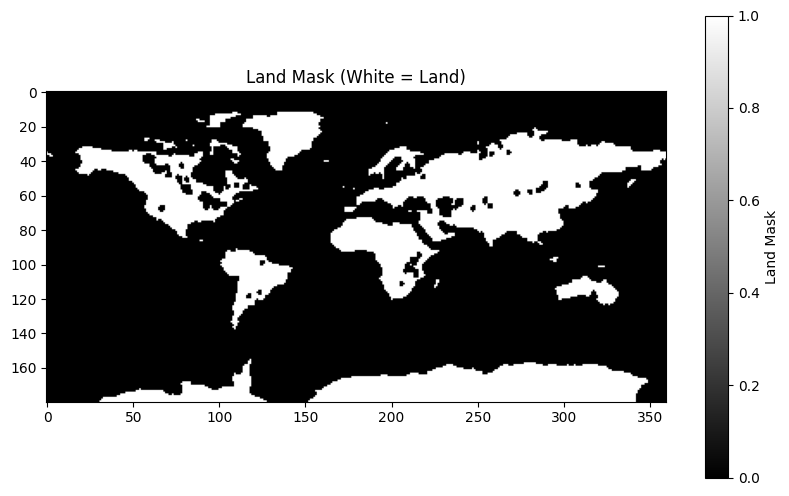

Land mask shape: (180, 360)
Epoch 1/20, Loss: 135.2702
Epoch 2/20, Loss: 114.2112
Epoch 3/20, Loss: 92.1402
Epoch 4/20, Loss: 75.0084
Epoch 5/20, Loss: 61.7187
Epoch 6/20, Loss: 51.2358
Epoch 7/20, Loss: 43.6314
Epoch 8/20, Loss: 36.2021
Epoch 9/20, Loss: 30.4813
Epoch 10/20, Loss: 26.2217
Epoch 11/20, Loss: 22.6600
Epoch 12/20, Loss: 19.4724
Epoch 13/20, Loss: 17.2435
Epoch 14/20, Loss: 16.4845
Epoch 15/20, Loss: 14.1035
Epoch 16/20, Loss: 13.1493
Epoch 17/20, Loss: 11.8999
Epoch 18/20, Loss: 11.5221
Epoch 19/20, Loss: 11.4030
Epoch 20/20, Loss: 10.0129
Average Spearman correlation over ocean: 0.9267


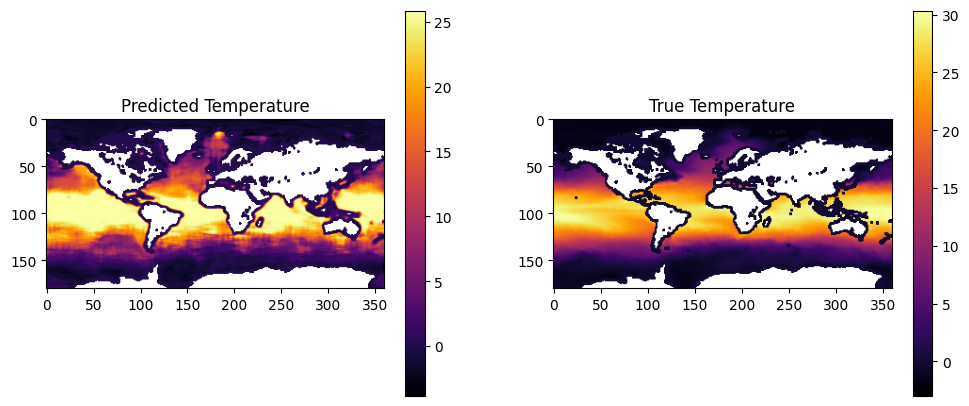

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from skimage.transform import resize

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Data Preprocessing ============
sequence_len = 3

class OceanDataset(Dataset):
    def __init__(self, file_paths, land_mask, sequence_length=sequence_len):
        self.sequence_length = sequence_length
        self.land_mask = land_mask
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        SSH = read_var(file_paths['SSH'], 'SSH')
        SST = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')
        ST = read_var(file_paths['depth1'], 'ST')

        SSH = resize(SSH, (SSH.shape[0], 180, 360), preserve_range=True)
        SST = resize(SST, (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)
        ST = resize(ST, (ST.shape[0], 180, 360), preserve_range=True)

        X = np.stack([SSH, SST, uSSW, vSSW], axis=1)
        y = ST

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i - self.sequence_length:i])
            targets.append(y[i])

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ ConvLSTM Model ============
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cells = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size)
            for i in range(num_layers)
        ])
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, self.hidden_dim, H, W).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_dim, H, W).to(x.device) for _ in range(self.num_layers)]

        for t in range(T):
            inp = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(inp, h[i], c[i])
                inp = h[i]

        # Removed unsqueeze(1) so that the output is of shape (B, 1, H, W)
        return self.conv_out(h[-1])

# ============ Training Loop ============
def train_model(model, train_loader, test_loader, land_mask, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='none')
    
    # Move the model to the device (GPU if available)
    model.to(device) 

    # Prepare land mask (H, W) -> (1, 1, H, W) for broadcasting
    land_mask_tensor = torch.tensor(land_mask, dtype=torch.bool).unsqueeze(0).unsqueeze(0).to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Calculate model outputs
            outputs = model(inputs) 
            
            B = outputs.size(0)

            # Reshape land mask to [B, 1, H, W]
            land_mask_tensor_reshaped = land_mask_tensor.expand(B, -1, -1, -1) 
            
            # Apply the mask to both the outputs and the targets (True = ocean)
            ocean_mask_outputs = ~land_mask_tensor_reshaped
            ocean_mask_targets = ~land_mask_tensor_reshaped

            # Calculate the loss using the masked outputs and targets
            loss_map = criterion(outputs[ocean_mask_outputs], targets[ocean_mask_targets])  
            loss = loss_map.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# ============ Testing Function ============
def test_model(model, test_loader, land_mask):
    model.eval()
    pred_list = []
    true_list = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            pred_list.append(preds.cpu().numpy())
            true_list.append(targets.cpu().numpy())

    pred_array = np.concatenate(pred_list, axis=0)
    true_array = np.concatenate(true_list, axis=0)

    land_mask = land_mask.astype(bool)
    spearman_scores = []

    for i in range(pred_array.shape[0]):
        pred = pred_array[i, 0]
        true = true_array[i, 0]
        ocean_mask = ~land_mask

        valid_preds = pred[ocean_mask]
        valid_true = true[ocean_mask]

        score, _ = spearmanr(valid_preds, valid_true)
        spearman_scores.append(score)

    print(f"Average Spearman correlation over ocean: {np.nanmean(spearman_scores):.4f}")

    # Plot example prediction
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.flipud(np.ma.masked_where(land_mask, pred_array[0, 0])), cmap='inferno')
    plt.title("Predicted Temperature")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(np.flipud(np.ma.masked_where(land_mask, true_array[0, 0])), cmap='inferno')
    plt.title("True Temperature")
    plt.colorbar()
    plt.show()

# ============ Create binary land mask from SST data ============
def create_land_mask_2(st_file_path='project_SST_1992-2021.nc', shape=(180, 360)):
    ds = netCDF4.Dataset(st_file_path)
    st_data_full = ds.variables['SST'][:]  # (T, H, W)
    st_data_full = np.ma.filled(st_data_full, fill_value=0)  # Fill masked values with 0

    # Resize each time slice
    resized_frames = [resize(frame, shape, preserve_range=True) for frame in st_data_full]
    st_resized_full = np.stack(resized_frames)

    # Compute the mean across time
    st_mean = np.mean(st_resized_full, axis=0)

    # Create the land mask where mean SST is below a threshold (land = True)
    land_mask = st_mean < 1e-3
    return land_mask

# Generate and plot the land mask using the SST-based approach
land_mask = create_land_mask_2()

plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(land_mask), cmap='gray')  # Flip vertically if desired
plt.title("Land Mask (White = Land)")
plt.colorbar(label='Land Mask')
plt.show()

print("Land mask shape:", land_mask.shape)

# ============ Run ============
file_paths = {
    'SSH': 'project_SSH_1992-2021.nc',
    'SST': 'project_SST_1992-2021.nc',
    'uSSW': 'project_uSSW_1992-2021.nc',
    'vSSW': 'project_vSSW_1992-2021.nc',
    'depth1': 'project_ST_1992-2021_dep-1.nc'
}

batch_size = 4

full_dataset = OceanDataset(file_paths, land_mask, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ConvLSTM(input_dim=4, hidden_dim=32, kernel_size=7, num_layers=2)

train_model(model, train_loader, test_loader, land_mask, epochs=20)
test_model(model, test_loader, land_mask)


Device: cuda


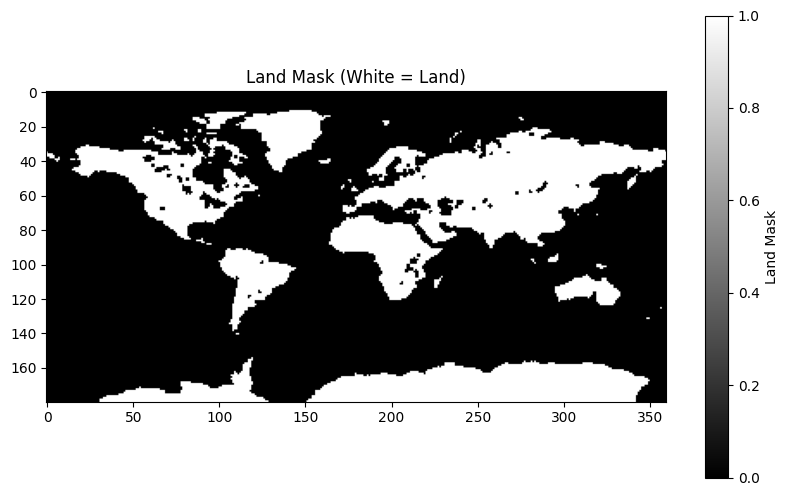

Land mask shape: (180, 360)
Epoch 1/20, Loss: 138.1971
Epoch 2/20, Loss: 122.5658
Epoch 3/20, Loss: 116.9469
Epoch 4/20, Loss: 92.8320
Epoch 5/20, Loss: 70.2240
Epoch 6/20, Loss: 55.9775
Epoch 7/20, Loss: 46.1238
Epoch 8/20, Loss: 37.1473
Epoch 9/20, Loss: 30.9719
Epoch 10/20, Loss: 26.0006
Epoch 11/20, Loss: 22.3267
Epoch 12/20, Loss: 19.7836
Epoch 13/20, Loss: 17.2927
Epoch 14/20, Loss: 15.6712
Epoch 15/20, Loss: 14.5181
Epoch 16/20, Loss: 13.4772
Epoch 17/20, Loss: 12.2703
Epoch 18/20, Loss: 12.0406
Epoch 19/20, Loss: 11.4662
Epoch 20/20, Loss: 10.3680
Average Spearman correlation over ocean: 0.9293


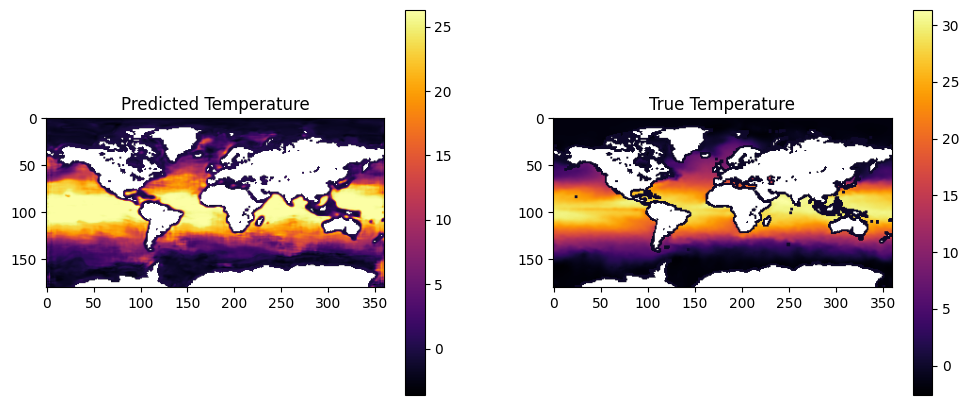

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from skimage.transform import resize

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Data Preprocessing ============
sequence_len = 3

class OceanDataset(Dataset):
    def __init__(self, file_paths, land_mask, sequence_length=sequence_len):
        self.sequence_length = sequence_length
        self.land_mask = land_mask
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        SSH = read_var(file_paths['SSH'], 'SSH')
        SST = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')
        ST = read_var(file_paths['depth1'], 'ST')

        SSH = resize(SSH, (SSH.shape[0], 180, 360), preserve_range=True)
        SST = resize(SST, (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)
        ST = resize(ST, (ST.shape[0], 180, 360), preserve_range=True)

        X = np.stack([SSH, SST, uSSW, vSSW], axis=1)
        y = ST

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i - self.sequence_length:i])
            targets.append(y[i])

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ ConvLSTM Model ============
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cells = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size)
            for i in range(num_layers)
        ])
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, self.hidden_dim, H, W).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_dim, H, W).to(x.device) for _ in range(self.num_layers)]

        for t in range(T):
            inp = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(inp, h[i], c[i])
                inp = h[i]

        # Removed unsqueeze(1) so that the output is of shape (B, 1, H, W)
        return self.conv_out(h[-1])

# ============ Training Loop ============
def train_model(model, train_loader, test_loader, land_mask, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='none')
    
    # Move the model to the device (GPU if available)
    model.to(device) 

    # Prepare land mask (H, W) -> (1, 1, H, W) for broadcasting
    land_mask_tensor = torch.tensor(land_mask, dtype=torch.bool).unsqueeze(0).unsqueeze(0).to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Calculate model outputs
            outputs = model(inputs) 
            
            B = outputs.size(0)

            # Reshape land mask to [B, 1, H, W]
            land_mask_tensor_reshaped = land_mask_tensor.expand(B, -1, -1, -1) 
            
            # Apply the mask to both the outputs and the targets (True = ocean)
            ocean_mask_outputs = ~land_mask_tensor_reshaped
            ocean_mask_targets = ~land_mask_tensor_reshaped

            # Calculate the loss using the masked outputs and targets
            loss_map = criterion(outputs[ocean_mask_outputs], targets[ocean_mask_targets])  
            loss = loss_map.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# ============ Testing Function ============
def test_model(model, test_loader, land_mask):
    model.eval()
    pred_list = []
    true_list = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            pred_list.append(preds.cpu().numpy())
            true_list.append(targets.cpu().numpy())

    pred_array = np.concatenate(pred_list, axis=0)
    true_array = np.concatenate(true_list, axis=0)

    land_mask = land_mask.astype(bool)
    spearman_scores = []

    for i in range(pred_array.shape[0]):
        pred = pred_array[i, 0]
        true = true_array[i, 0]
        ocean_mask = ~land_mask

        valid_preds = pred[ocean_mask]
        valid_true = true[ocean_mask]

        score, _ = spearmanr(valid_preds, valid_true)
        spearman_scores.append(score)

    print(f"Average Spearman correlation over ocean: {np.nanmean(spearman_scores):.4f}")

    # Plot example prediction
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.flipud(np.ma.masked_where(land_mask, pred_array[0, 0])), cmap='inferno')
    plt.title("Predicted Temperature")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(np.flipud(np.ma.masked_where(land_mask, true_array[0, 0])), cmap='inferno')
    plt.title("True Temperature")
    plt.colorbar()
    plt.show()

# ============ Create binary land mask from SST data ============
def create_land_mask_2(st_file_path='project_SST_1992-2021.nc', shape=(180, 360)):
    ds = netCDF4.Dataset(st_file_path)
    st_data_full = ds.variables['SST'][:]  # (T, H, W)
    st_data_full = np.ma.filled(st_data_full, fill_value=0)  # Fill masked values with 0

    # Resize each time slice
    resized_frames = [resize(frame, shape, preserve_range=True) for frame in st_data_full]
    st_resized_full = np.stack(resized_frames)

    # Compute the mean across time
    st_mean = np.mean(st_resized_full, axis=0)

    # Create the land mask where mean SST is below a threshold (land = True)
    land_mask = st_mean < 1
    return land_mask

# Generate and plot the land mask using the SST-based approach
land_mask = create_land_mask_2()

plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(land_mask), cmap='gray')  # Flip vertically if desired
plt.title("Land Mask (White = Land)")
plt.colorbar(label='Land Mask')
plt.show()

print("Land mask shape:", land_mask.shape)

# ============ Run ============
file_paths = {
    'SSH': 'project_SSH_1992-2021.nc',
    'SST': 'project_SST_1992-2021.nc',
    'uSSW': 'project_uSSW_1992-2021.nc',
    'vSSW': 'project_vSSW_1992-2021.nc',
    'depth1': 'project_ST_1992-2021_dep-1.nc'
}

batch_size = 4

full_dataset = OceanDataset(file_paths, land_mask, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ConvLSTM(input_dim=4, hidden_dim=32, kernel_size=7, num_layers=2)

train_model(model, train_loader, test_loader, land_mask, epochs=20)
test_model(model, test_loader, land_mask)
